#  EDA and Feature engineering

In [64]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from tabulate import tabulate
import matplotlib.pyplot as plt
import seaborn as sns

# --- Load data ---
train = pd.read_csv('/kaggle/input/walmart-store-sales-forecasting/train.csv', parse_dates=['Date'])
stores = pd.read_csv('/kaggle/input/walmart-store-sales-forecasting/stores.csv')
features = pd.read_csv('/kaggle/input/walmart-store-sales-forecasting/features.csv', parse_dates=['Date'])

# --- Merge data ---
df = train.merge(stores, on='Store', how='left')
df = df.merge(features, on=['Store', 'Date'], how='left')

#df.to_csv('Ntrain.csv', index=False)

In [65]:
# --- Drop duplicates ---
df.drop_duplicates(inplace=True)

# --- Handle missing values ---
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df[markdown_cols] = df[markdown_cols].fillna(0)

# CPI and Unemployment forward filled per Store
df.sort_values(['Store', 'Date'], inplace=True)
df[['CPI', 'Unemployment']] = df.groupby('Store')[['CPI', 'Unemployment']].ffill()

# Backfill remaining missing values
df['CPI'] = df['CPI'].bfill()
df['Unemployment'] = df['Unemployment'].bfill()



if 'IsHoliday_x' in df.columns:
    df.drop('IsHoliday_x', axis=1, inplace=True)


# Rename 'IsHoliday_y' to 'IsHoliday'
df.rename(columns={'IsHoliday_y': 'IsHoliday'}, inplace=True)


# --- Feature Engineering ---
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Week'] = df['Date'].dt.isocalendar().week.astype(int)
df['Day'] = df['Date'].dt.day

# --- Encode categorical ---
le = LabelEncoder()
df['Type'] = le.fit_transform(df['Type'])


# For Better Table View 
exclude = {'MarkDown2', 'MarkDown3', 'MarkDown4'}
cols_to_show = [col for col in df.columns if col not in exclude]
print(tabulate(df[cols_to_show].tail(10), headers='keys', tablefmt='psql', showindex=False))
print(df.columns.tolist())

+---------+--------+---------------------+----------------+--------+--------+---------------+--------------+-------------+-------------+---------+----------------+-------------+--------+---------+--------+-------+
|   Store |   Dept | Date                |   Weekly_Sales |   Type |   Size |   Temperature |   Fuel_Price |   MarkDown1 |   MarkDown5 |     CPI |   Unemployment | IsHoliday   |   Year |   Month |   Week |   Day |
|---------+--------+---------------------+----------------+--------+--------+---------------+--------------+-------------+-------------+---------+----------------+-------------+--------+---------+--------+-------|
|      45 |     85 | 2012-10-26 00:00:00 |        1689.1  |      1 | 118221 |         58.85 |        3.882 |     4018.91 |      858.33 | 192.309 |          8.667 | False       |   2012 |      10 |     43 |    26 |
|      45 |     87 | 2012-10-26 00:00:00 |        8187.66 |      1 | 118221 |         58.85 |        3.882 |     4018.91 |      858.33 | 192.309

# Visulization to Undestand Dataset

# Total Weekly Sales Over Time (Trend + Seasonality Insight)

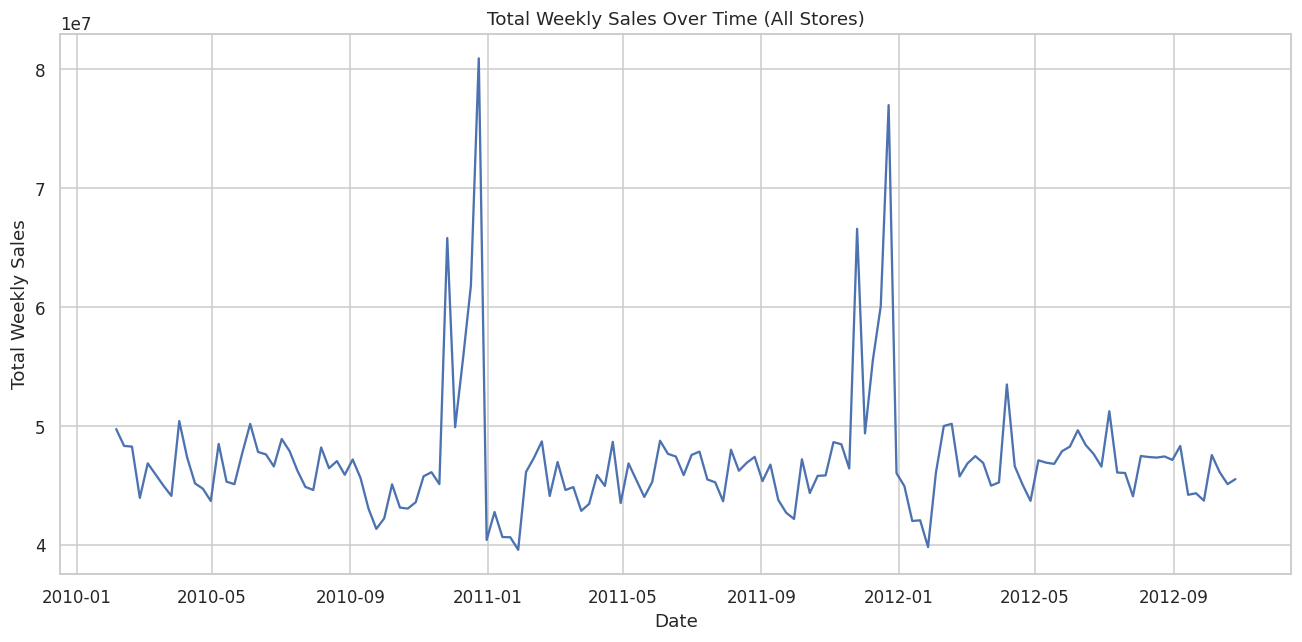

In [66]:
sales_time = df.groupby('Date')['Weekly_Sales'].sum().reset_index()
plt.figure(figsize=(12,6))
sns.lineplot(data=sales_time, x='Date', y='Weekly_Sales')
plt.title('Total Weekly Sales Over Time (All Stores)')
plt.xlabel('Date')
plt.ylabel('Total Weekly Sales')
plt.tight_layout()
plt.show()

> Sales show strong seasonal patterns with spikes during major holidays like Thanksgiving and Christmas, reflecting shopper behavior and marketing impact>

# Seasonal Decomposition of Weekly Sales

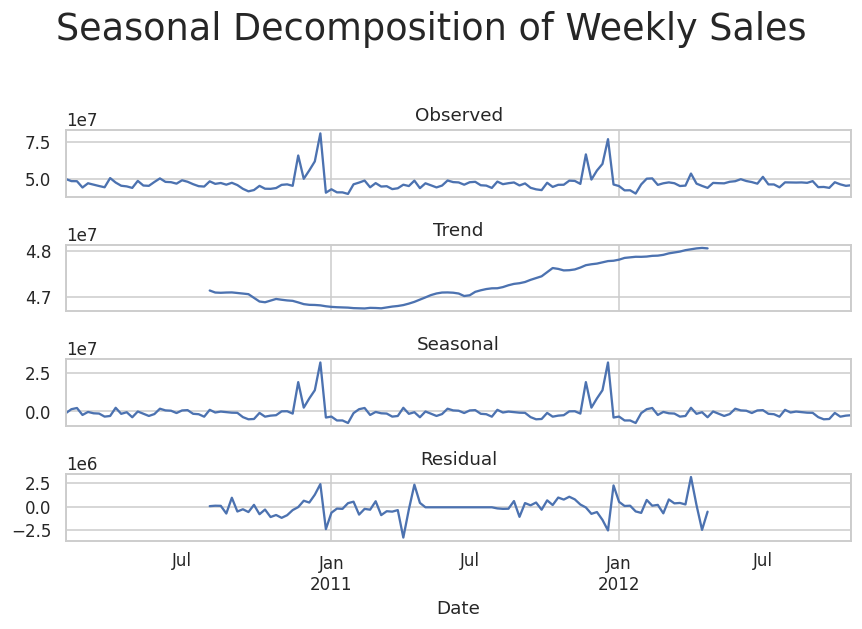

In [67]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Group weekly sales by date
weekly_sales = df.groupby('Date')['Weekly_Sales'].sum()

# Perform seasonal decomposition
decomp = seasonal_decompose(weekly_sales, model='additive', period=52)

# Manually create a wider figure
fig, axes = plt.subplots(4, 1, figsize=(8, 6), sharex=True)

# Plot each component on its own axis
decomp.observed.plot(ax=axes[0], title='Observed')
decomp.trend.plot(ax=axes[1], title='Trend')
decomp.seasonal.plot(ax=axes[2], title='Seasonal')
decomp.resid.plot(ax=axes[3], title='Residual')

# Add overall title and layout adjustments
fig.suptitle('Seasonal Decomposition of Weekly Sales', fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Make room for the suptitle
plt.show()

> Decomposition reveals a clear upward trend over years and strong seasonal spikes annually, crucial for forecasting and inventory planning

# Sales Distribution by Store Type

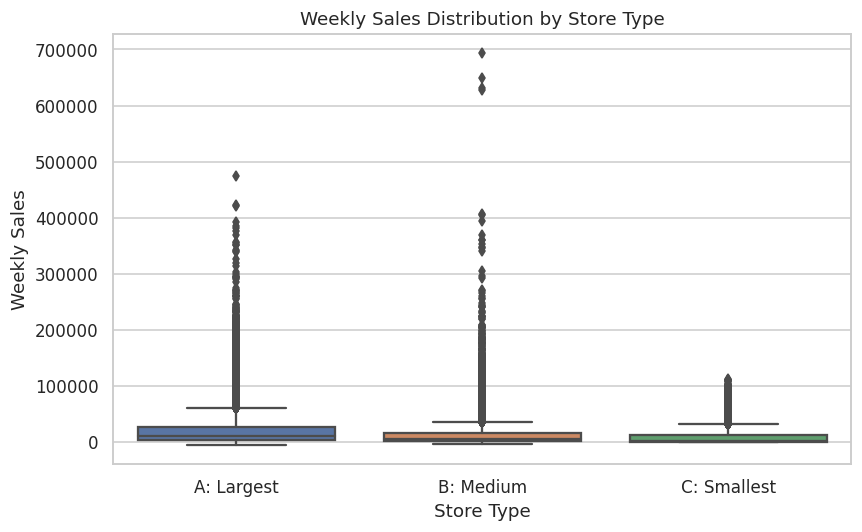

In [68]:
# Map encoded Type back to labels for clear plotting
type_map = {0: 'A: Largest', 1: 'B: Medium', 2: 'C: Smallest'}
df['Type_label'] = df['Type'].map(type_map)

plt.figure(figsize=(8,5))
sns.boxplot(data=df, x='Type_label', y='Weekly_Sales')
plt.title('Weekly Sales Distribution by Store Type')
plt.xlabel('Store Type')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()

> Largest stores (Type A) show higher and more consistent weekly sales, while smaller stores (Type C) have wider variation and lower median sales.

# Average Sales: Holiday vs Non-Holiday

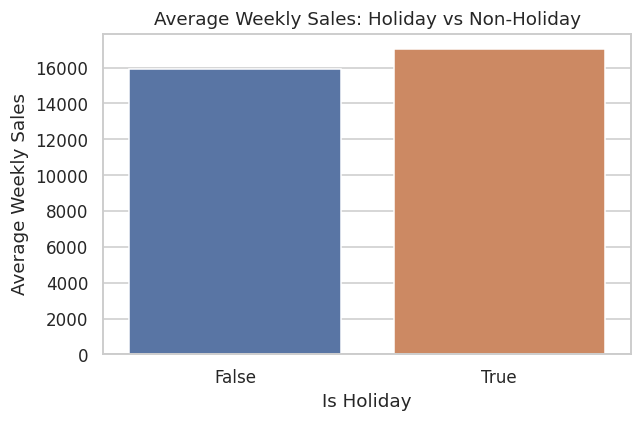

In [69]:
holiday_sales = df.groupby('IsHoliday')['Weekly_Sales'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=holiday_sales, x='IsHoliday', y='Weekly_Sales')
plt.title('Average Weekly Sales: Holiday vs Non-Holiday')
plt.xlabel('Is Holiday')
plt.ylabel('Average Weekly Sales')
plt.tight_layout()
plt.show()

> Average sales increase significantly during holiday weeks across all stores, reflecting consumer spending spikes

# Markdown1 vs Weekly Sales (Sampled Scatterplot)

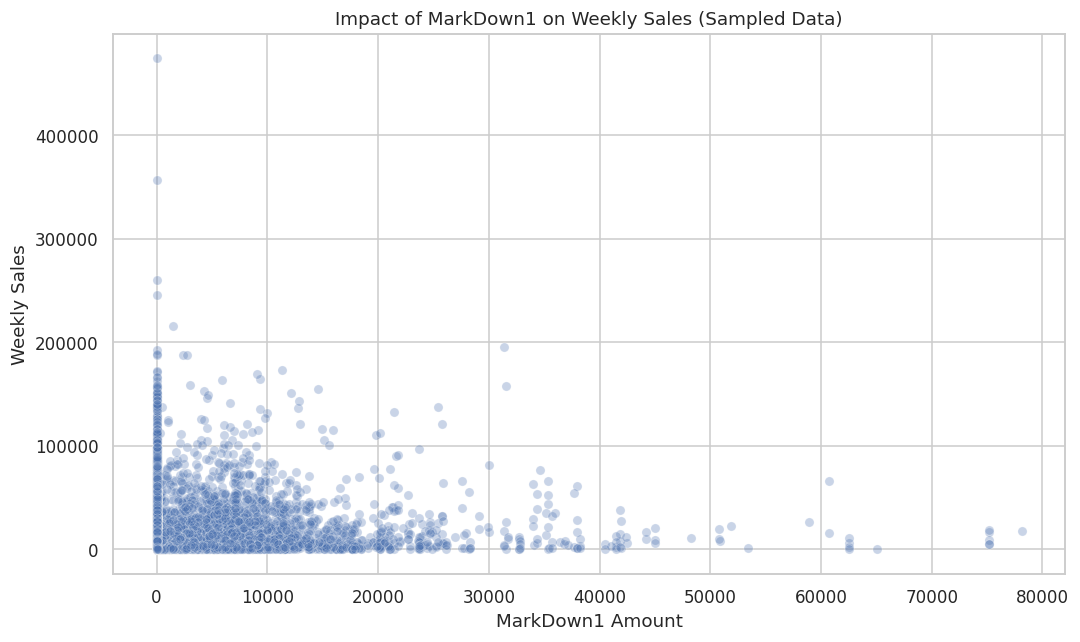

In [70]:
plt.figure(figsize=(10,6))
sns.scatterplot(x='MarkDown1', y='Weekly_Sales', data=df.sample(10000, random_state=42), alpha=0.3)
plt.title('Impact of MarkDown1 on Weekly Sales (Sampled Data)')
plt.xlabel('MarkDown1 Amount')
plt.ylabel('Weekly Sales')
plt.tight_layout()
plt.show()

> Higher markdown amounts generally correlate with increased sales, indicating markdowns effectively boost customer purchases

# Top 10 Departments by Total Sales

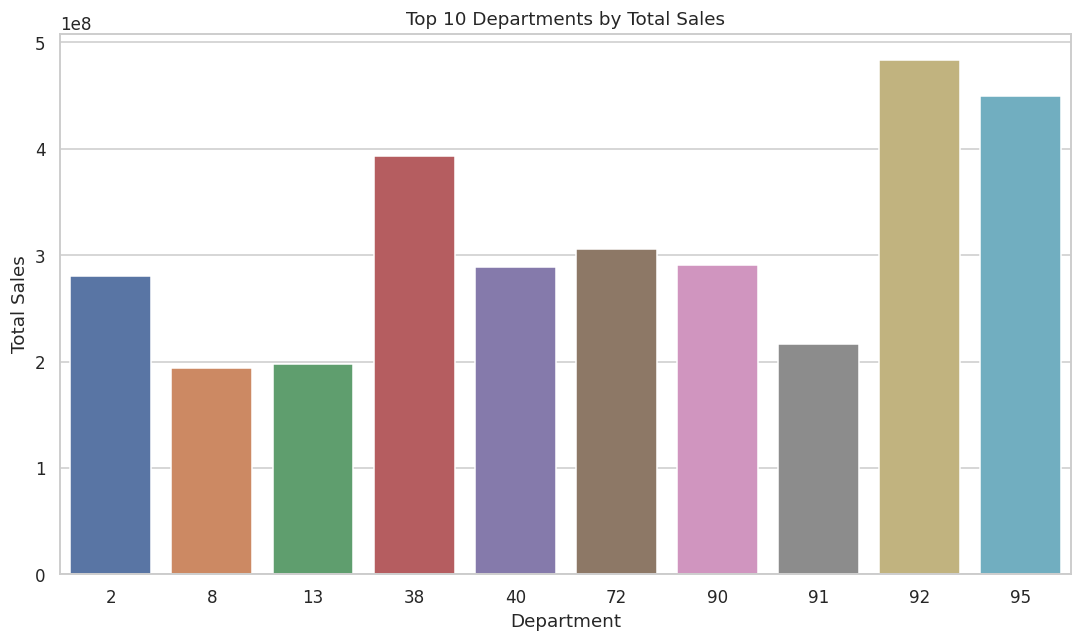

In [71]:
top_depts = df.groupby('Dept')['Weekly_Sales'].sum().nlargest(10).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(data=top_depts, x='Dept', y='Weekly_Sales')
plt.title('Top 10 Departments by Total Sales')
plt.xlabel('Department')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

> Departments 92, 95, and 38 dominate total sales, likely representing popular product categories.

# Holiday vs Non-Holiday Sales Trend by Store Type

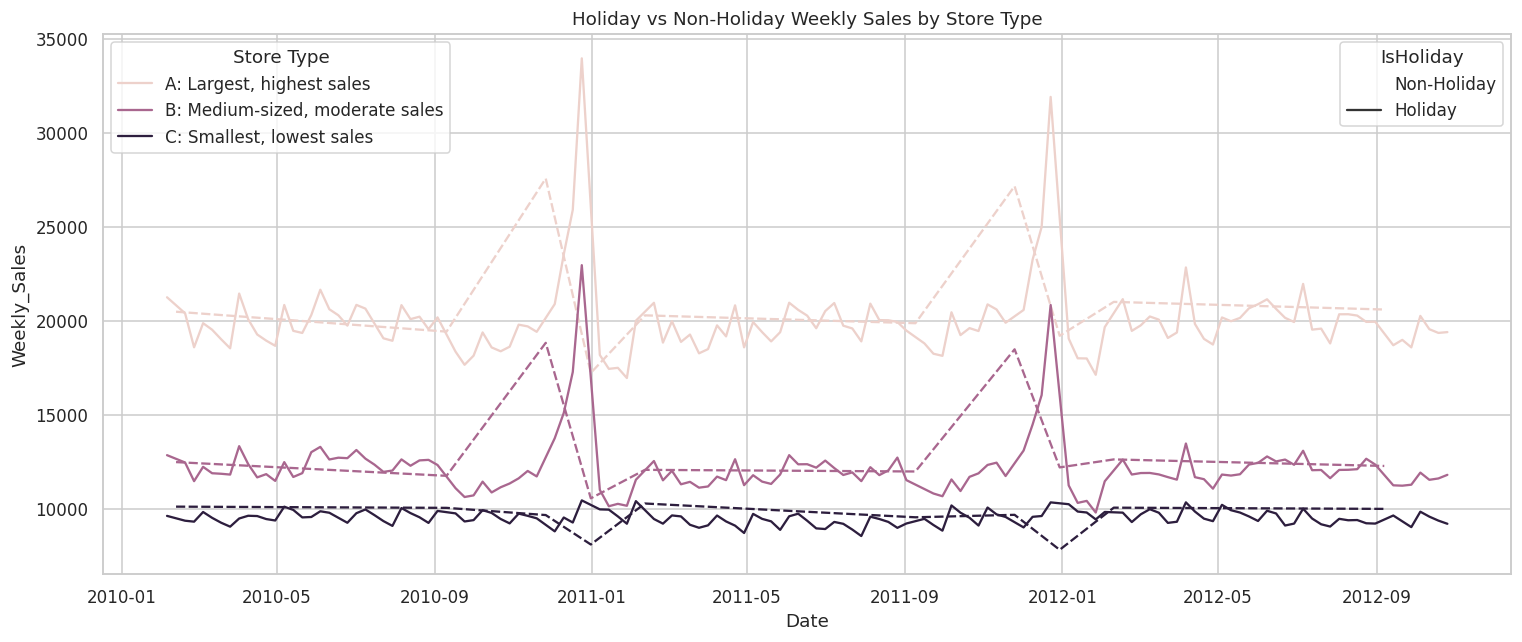

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns

holiday_trend = df.groupby(['Date', 'Type', 'IsHoliday'])['Weekly_Sales'].mean().reset_index()

plt.figure(figsize=(14,6))
ax = sns.lineplot(data=holiday_trend, x='Date', y='Weekly_Sales', hue='Type', style='IsHoliday')

ax.set_title('Holiday vs Non-Holiday Weekly Sales by Store Type')

# Define concise labels for Types
type_labels = [
    'A: Largest, highest sales',
    'B: Medium-sized, moderate sales',
    'C: Smallest, lowest sales'
]

# Extract current legend handles and labels
handles, labels = ax.get_legend_handles_labels()

# Separate handles for Type and IsHoliday
type_handles = handles[1:4]
style_handles = handles[4:6]

# Create combined legend
from matplotlib.legend import Legend

# Remove existing legend first
ax.legend_.remove()

# Add Type legend
legend1 = ax.legend(type_handles, type_labels, title='Store Type', loc='upper left')

# Add IsHoliday legend
legend2 = plt.legend(style_handles, ['Non-Holiday', 'Holiday'], title='IsHoliday', loc='upper right')

# Add both legends manually
ax.add_artist(legend1)

plt.tight_layout()
plt.show()

> Holiday weeks consistently boost sales across all store types, with largest stores (Type A) showing highest baseline sales

In [73]:
# 1. Holiday vs Non-Holiday Sales Increase
holiday_sales = df[df['IsHoliday'] == True]['Weekly_Sales'].mean()
non_holiday_sales = df[df['IsHoliday'] == False]['Weekly_Sales'].mean()
holiday_increase_pct = ((holiday_sales - non_holiday_sales) / non_holiday_sales) * 100

# 2. Store Size Impact (Median sales difference: Type A vs B & C)
median_sales_by_type = df.groupby('Type')['Weekly_Sales'].median()
large_store_sales = median_sales_by_type[0]   # Assuming 0 = 'A'
smaller_store_sales = median_sales_by_type[[1, 2]].mean()  # 1,2 = 'B','C'
store_size_diff_pct = ((large_store_sales - smaller_store_sales) / smaller_store_sales) * 100

# 3. Holiday Sales Increase by Store Type
holiday_sales_by_type = df[df['IsHoliday'] == True].groupby('Type')['Weekly_Sales'].mean()
non_holiday_sales_by_type = df[df['IsHoliday'] == False].groupby('Type')['Weekly_Sales'].mean()
holiday_increase_by_type_pct = ((holiday_sales_by_type - non_holiday_sales_by_type) / non_holiday_sales_by_type) * 100

# 4. Markdown1 Impact on Sales
markdown_sales = df[df['MarkDown1'] > 0]['Weekly_Sales'].mean()
no_markdown_sales = df[df['MarkDown1'] == 0]['Weekly_Sales'].mean()
markdown_uplift_pct = ((markdown_sales - no_markdown_sales) / no_markdown_sales) * 100

# 5. Top 10 Departments Contribution to Total Sales
total_sales = df['Weekly_Sales'].sum()
sales_by_dept = df.groupby('Dept')['Weekly_Sales'].sum().sort_values(ascending=False)
top_10_sales = sales_by_dept.head(10).sum()
top_10_contribution_pct = (top_10_sales / total_sales) * 100

# Print all results
print(f"Holiday sales increase: {holiday_increase_pct:.2f}%")
print(f"Large store vs smaller store median sales difference: {store_size_diff_pct:.2f}%")
print("Holiday sales increase by store type (%):")
print(holiday_increase_by_type_pct.round(2))
print(f"Markdown1 sales uplift: {markdown_uplift_pct:.2f}%")
print(f"Top 10 departments contribution to total sales: {top_10_contribution_pct:.2f}%")

Holiday sales increase: 7.13%
Large store vs smaller store median sales difference: 175.44%
Holiday sales increase by store type (%):
Type
0    6.44
1    9.82
2    0.15
Name: Weekly_Sales, dtype: float64
Markdown1 sales uplift: 2.30%
Top 10 departments contribution to total sales: 46.03%


# Bar chart visualization showing RMSE, MAE, and R²

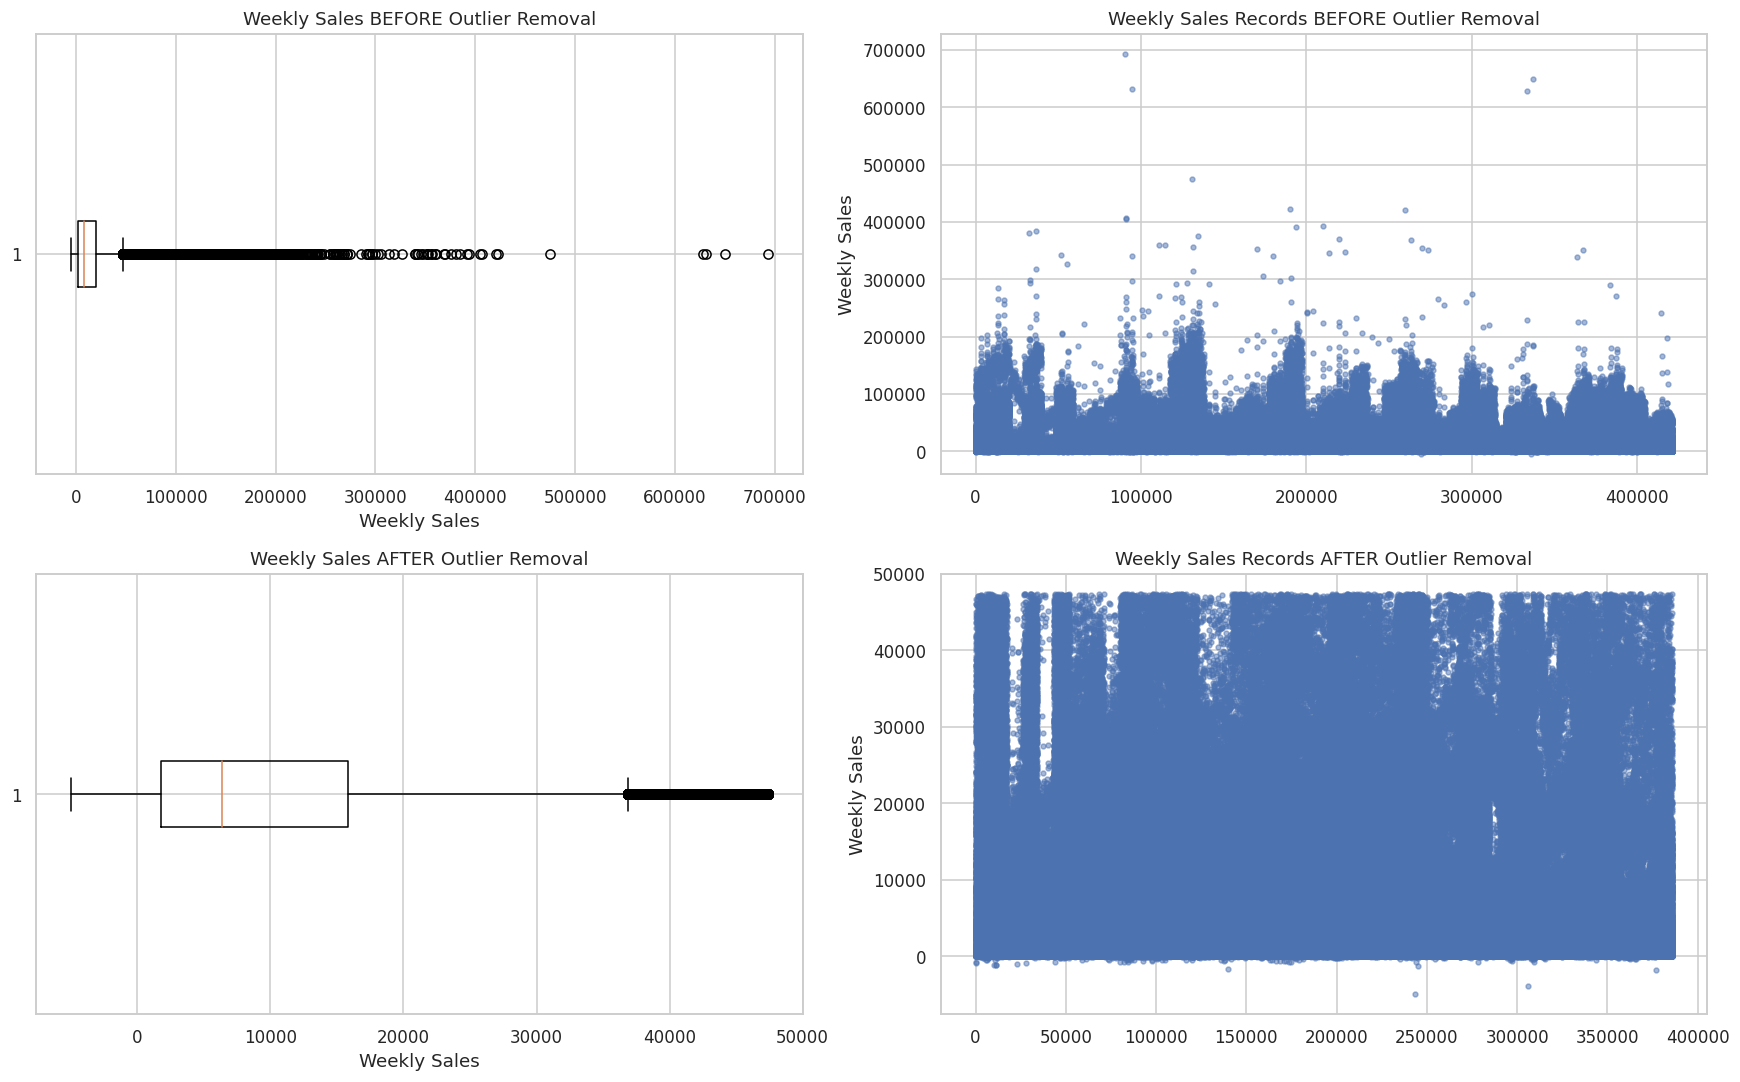

In [74]:
import matplotlib.pyplot as plt

# Remove outliers using IQR
Q1 = df['Weekly_Sales'].quantile(0.25)
Q3 = df['Weekly_Sales'].quantile(0.75)
IQR = Q3 - Q1
df_no_outliers = df[(df['Weekly_Sales'] >= Q1 - 1.5*IQR) & (df['Weekly_Sales'] <= Q3 + 1.5*IQR)]

# Combined figure
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# ------------------------
# Boxplots
# ------------------------
axes[0,0].boxplot(df['Weekly_Sales'], vert=False)
axes[0,0].set_title('Weekly Sales BEFORE Outlier Removal')
axes[0,0].set_xlabel('Weekly Sales')

axes[1,0].boxplot(df_no_outliers['Weekly_Sales'], vert=False)
axes[1,0].set_title('Weekly Sales AFTER Outlier Removal')
axes[1,0].set_xlabel('Weekly Sales')

# ------------------------
# Scatter plots
# ------------------------
axes[0,1].scatter(range(len(df)), df['Weekly_Sales'], s=10, alpha=0.5)
axes[0,1].set_title('Weekly Sales Records BEFORE Outlier Removal')
axes[0,1].set_ylabel('Weekly Sales')

axes[1,1].scatter(range(len(df_no_outliers)), df_no_outliers['Weekly_Sales'], s=10, alpha=0.5)
axes[1,1].set_title('Weekly Sales Records AFTER Outlier Removal')
axes[1,1].set_ylabel('Weekly Sales')

plt.tight_layout()
plt.show()


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.032502 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3833
[LightGBM] [Info] Number of data points in the train set: 398957, number of used features: 23
[LightGBM] [Info] Start training from score 16033.277703
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.025404 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3834
[LightGBM] [Info] Number of data points in the train set: 365313, number of used features: 23
[LightGBM] [Info] Start training from score 10589.409614
                               RMSE          MAE        R2
IQR Removal - XGB       1528.508637   893.284559  0.981433
IQR Removal - LGBM      1540.353230   902.056268  0.981144
I

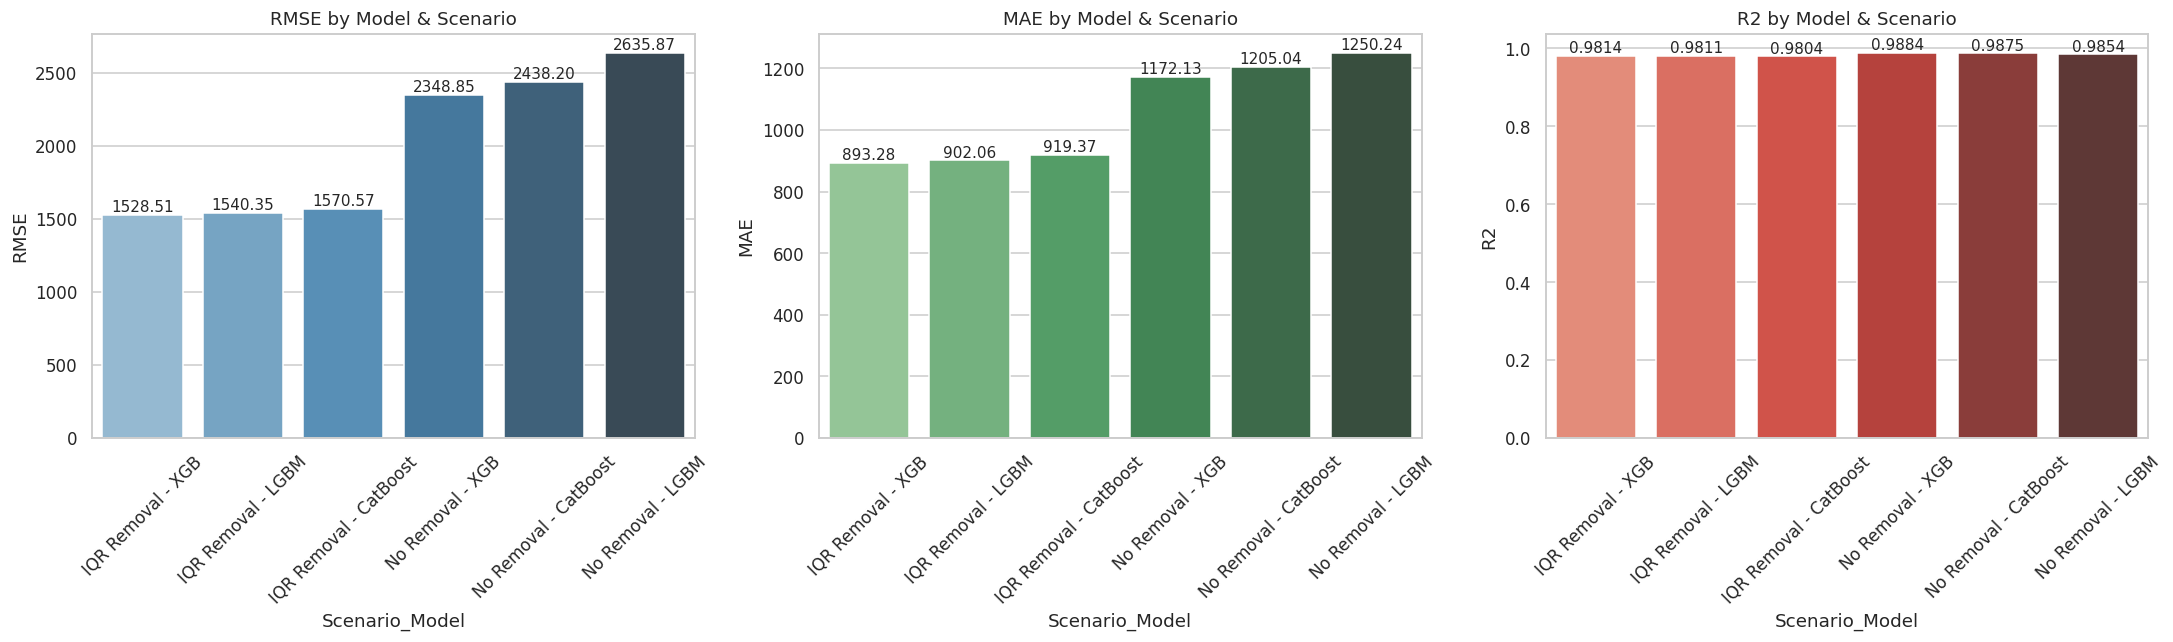

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ------------------------
# 4️⃣ Lag & Rolling (per Store-Dept)
# ------------------------
TARGET = 'Weekly_Sales'
for lag in [1,2,3]:
    df[f'Lag_{lag}'] = df.groupby(['Store','Dept'])[TARGET].shift(lag)
df['Rolling_Mean_4'] = df.groupby(['Store','Dept'])[TARGET].shift(1).rolling(4).mean()
df['Rolling_Std_4']  = df.groupby(['Store','Dept'])[TARGET].shift(1).rolling(4).std()

df_tree = df.dropna(subset=['Lag_1','Lag_2','Lag_3','Rolling_Mean_4','Rolling_Std_4']).copy()

tree_feats = [
    'Store','Dept','Type','IsHoliday','Size','Temperature','Fuel_Price',
    'CPI','Unemployment','MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5',
    'Year','Month','Week','Day',
    'Lag_1','Lag_2','Lag_3','Rolling_Mean_4','Rolling_Std_4'
]

# ------------------------
# 5️⃣ Outlier Removal Functions
# ------------------------
def remove_outliers_iqr(data):
    Q1 = data[TARGET].quantile(0.25)
    Q3 = data[TARGET].quantile(0.75)
    IQR = Q3 - Q1
    return data[(data[TARGET] >= Q1 - 1.5*IQR) & (data[TARGET] <= Q3 + 1.5*IQR)]

# ------------------------
# 6️⃣ Train/Evaluate Function
# ------------------------
def train_and_evaluate(X_train, X_test, y_train, y_test):
    models = {
        'XGB': XGBRegressor(random_state=RANDOM_STATE, n_estimators=929, learning_rate=0.08, max_depth=7, subsample=0.8, colsample_bytree=0.8, tree_method='hist'),
        'LGBM': LGBMRegressor(random_state=RANDOM_STATE, n_estimators=1000, learning_rate=0.05, subsample=0.8, colsample_bytree=0.8),
        'CatBoost': CatBoostRegressor(random_seed=RANDOM_STATE, iterations=1000, learning_rate=0.05, depth=8, verbose=0)
    }
    results = {}
    for name, model in models.items():
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        results[name] = {
            'RMSE': mean_squared_error(y_test, preds, squared=False),
            'MAE': mean_absolute_error(y_test, preds),
            'R2': r2_score(y_test, preds)
        }
    return results

# ------------------------
# 7️⃣ Run Scenarios
# ------------------------
scenarios = {
    'No Removal': df_tree.copy(),
    'IQR Removal': remove_outliers_iqr(df_tree.copy()),
}

all_results = {}
for scenario_name, scenario_df in scenarios.items():
    train_df = scenario_df[scenario_df['Date'] < '2012-10-01']
    test_df = scenario_df[scenario_df['Date'] >= '2012-10-01']
    
    X_train, y_train = train_df[tree_feats], train_df[TARGET]
    X_test, y_test = test_df[tree_feats], test_df[TARGET]
    
    results = train_and_evaluate(X_train, X_test, y_train, y_test)
    for model_name, metrics in results.items():
        all_results[f"{scenario_name} - {model_name}"] = metrics

metrics_df = pd.DataFrame(all_results).T[['RMSE','MAE','R2']].sort_values('RMSE')
print(metrics_df)

# ------------------------
# 8️⃣ Plot Vertical Bar Charts with Values on Top
# ------------------------
metrics_plot = metrics_df.reset_index().rename(columns={'index': 'Scenario_Model'})
sns.set(style="whitegrid")

def add_labels(ax, fmt="{:.2f}"):
    for p in ax.patches:
        ax.annotate(fmt.format(p.get_height()),
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

sns.barplot(x='Scenario_Model', y='RMSE', data=metrics_plot, ax=axes[0], palette="Blues_d")
axes[0].set_title('RMSE by Model & Scenario')
axes[0].tick_params(axis='x', rotation=45)
add_labels(axes[0])

sns.barplot(x='Scenario_Model', y='MAE', data=metrics_plot, ax=axes[1], palette="Greens_d")
axes[1].set_title('MAE by Model & Scenario')
axes[1].tick_params(axis='x', rotation=45)
add_labels(axes[1])

# Function to add labels with 4 decimal places
def add_labels_4f(ax):
    for p in ax.patches:
        ax.annotate(f"{p.get_height():.4f}",
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', fontsize=10)

# R2 barplot
sns.barplot(x='Scenario_Model', y='R2', data=metrics_plot, ax=axes[2], palette="Reds_d")
axes[2].set_title('R2 by Model & Scenario')
axes[2].tick_params(axis='x', rotation=45)
add_labels_4f(axes[2])

plt.tight_layout()
plt.show()

> We compared three models; XGBoost performed best on RMSE and MAE, so we used it for final forecasts”, it actually looks professional.


> We tested two outlier removal strategies — removing all statistical outliers via IQR and removing only extreme high sales spikes.IQR consistently outperformed both the spike-only removal and the no-removal baseline, cutting RMSE by ~35% while preserving R², indicating reduced variance without loss of overall fit.> 


Training XGB...
Training LGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 375126, number of used features: 22
[LightGBM] [Info] Start training from score 10548.214894
Training CatBoost...


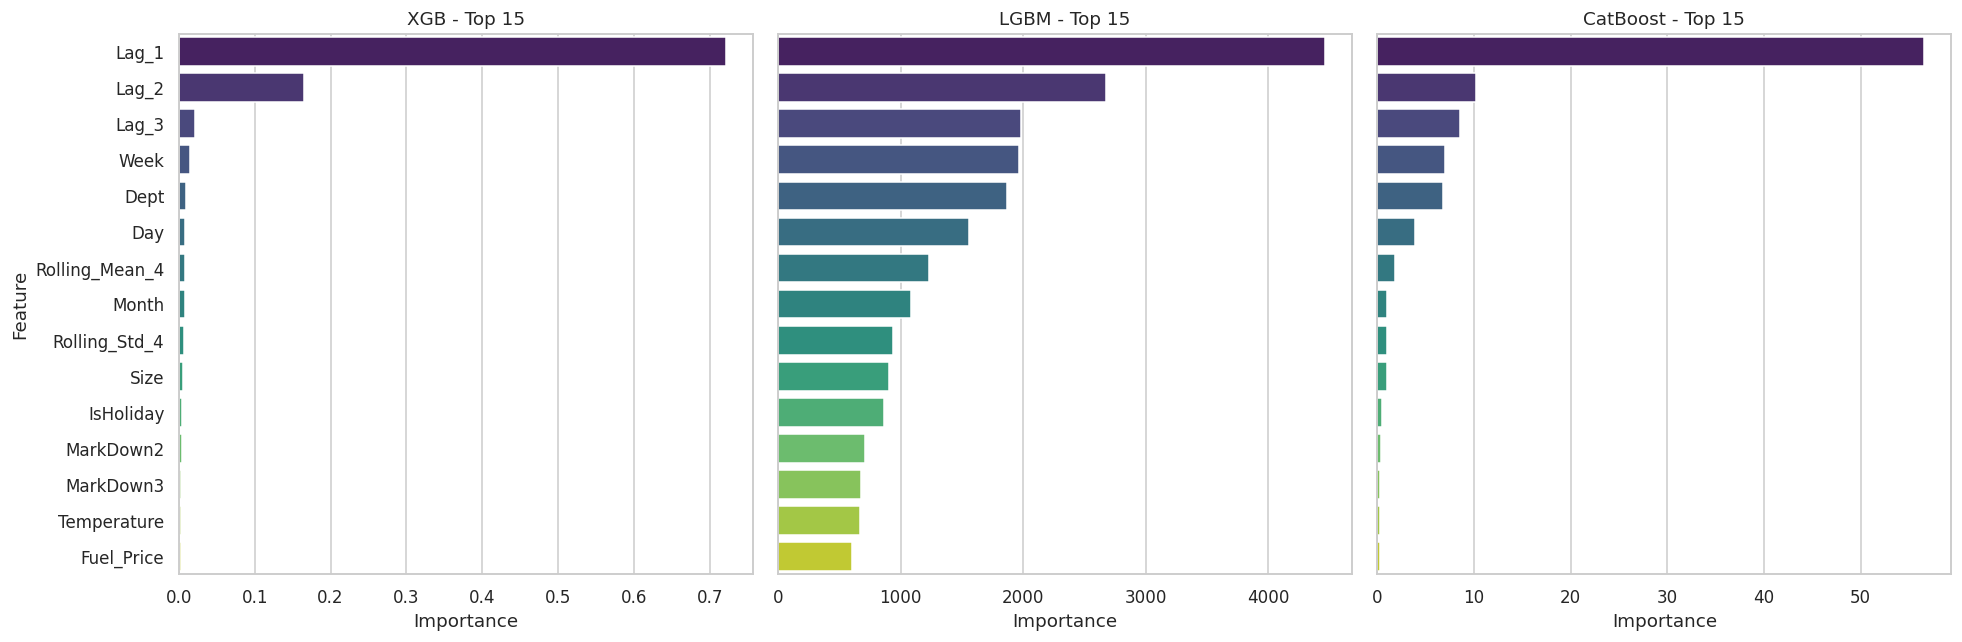

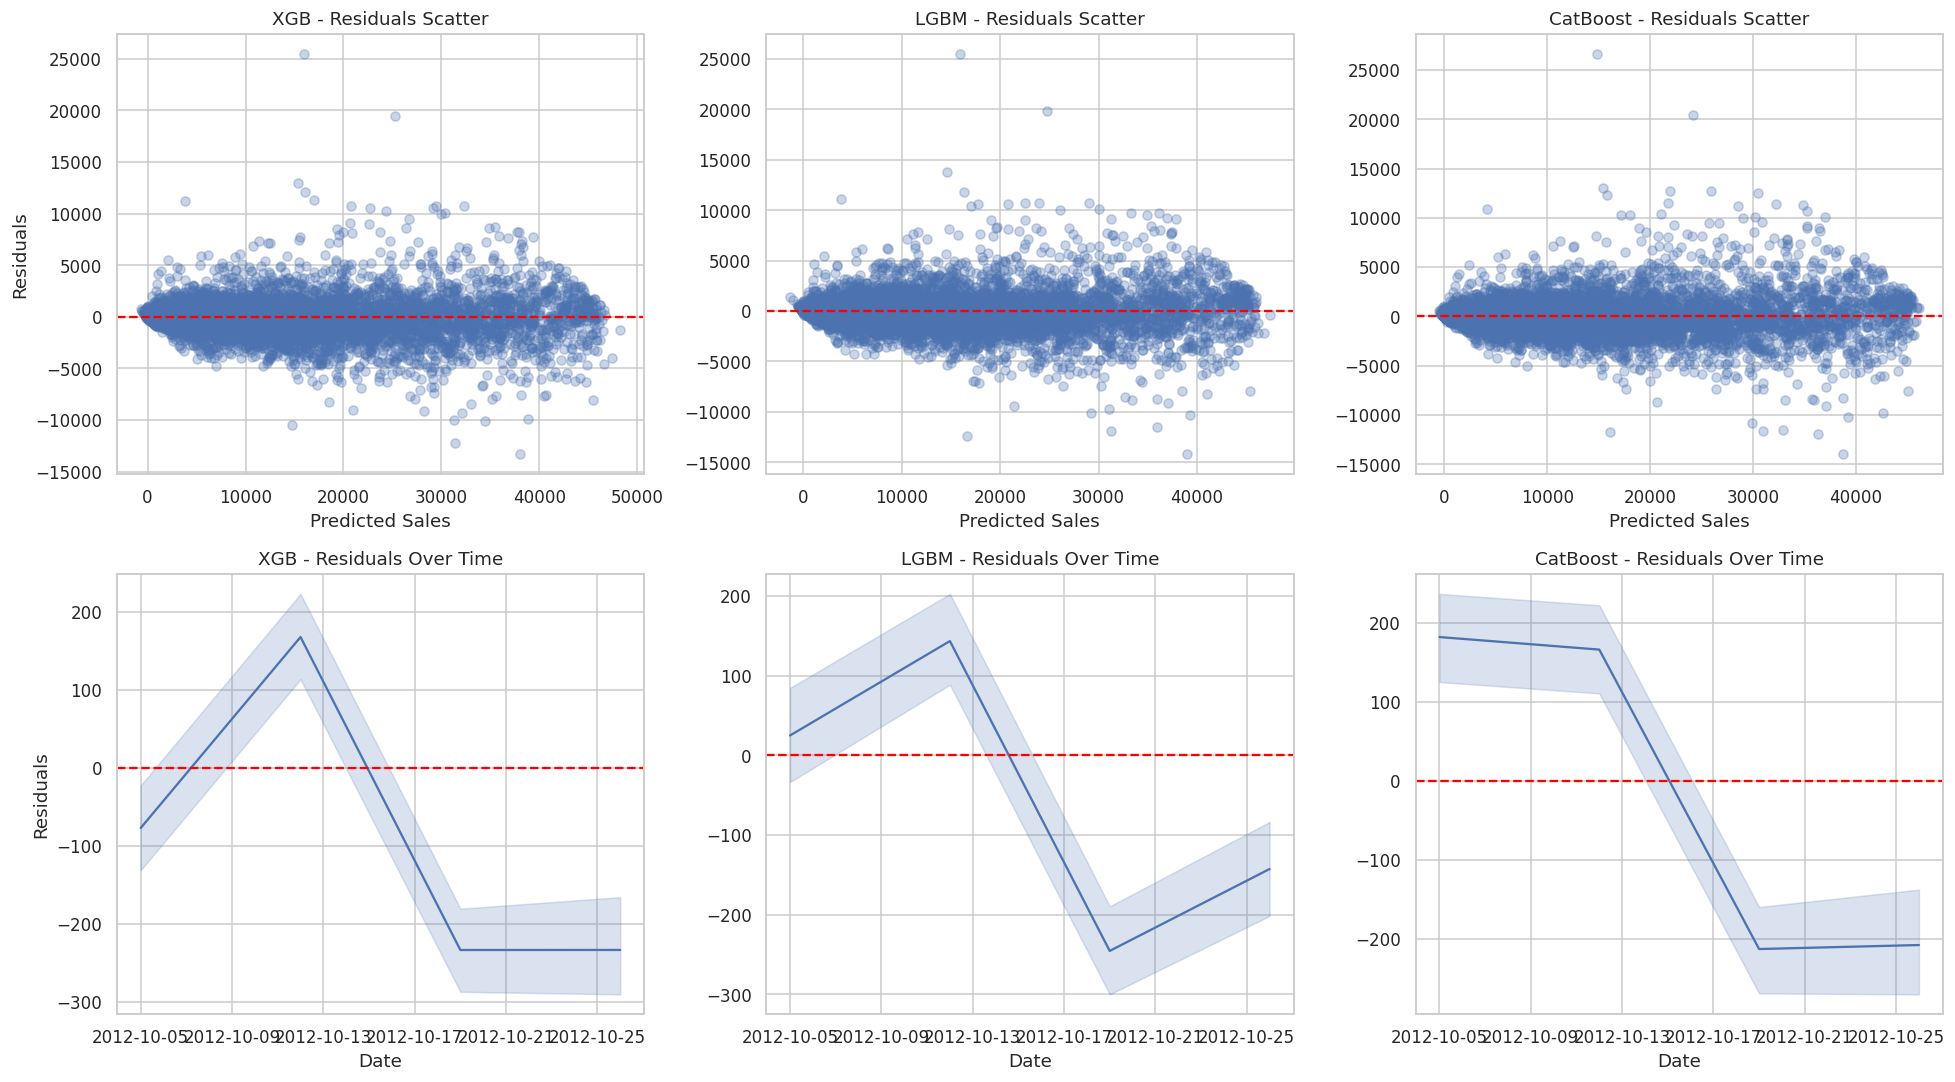

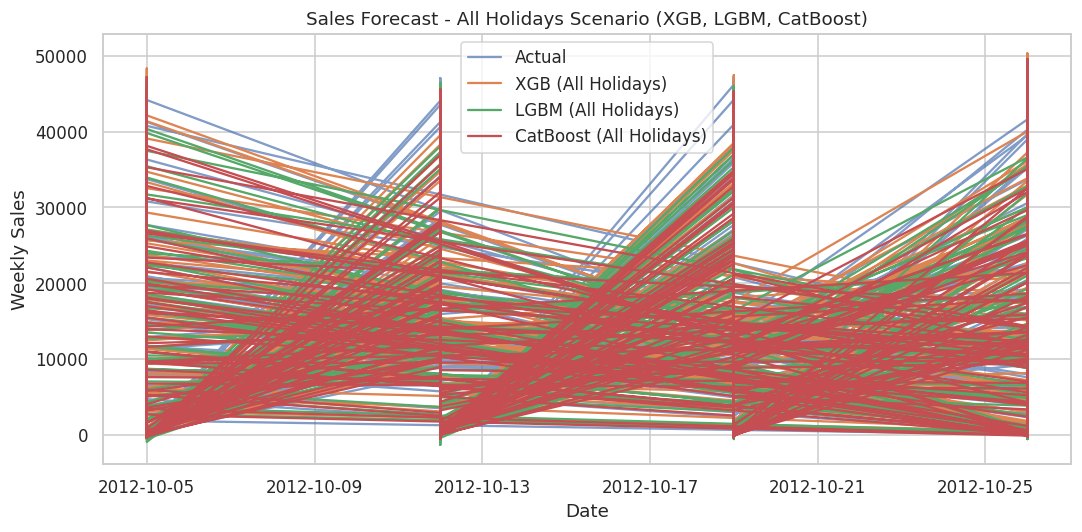

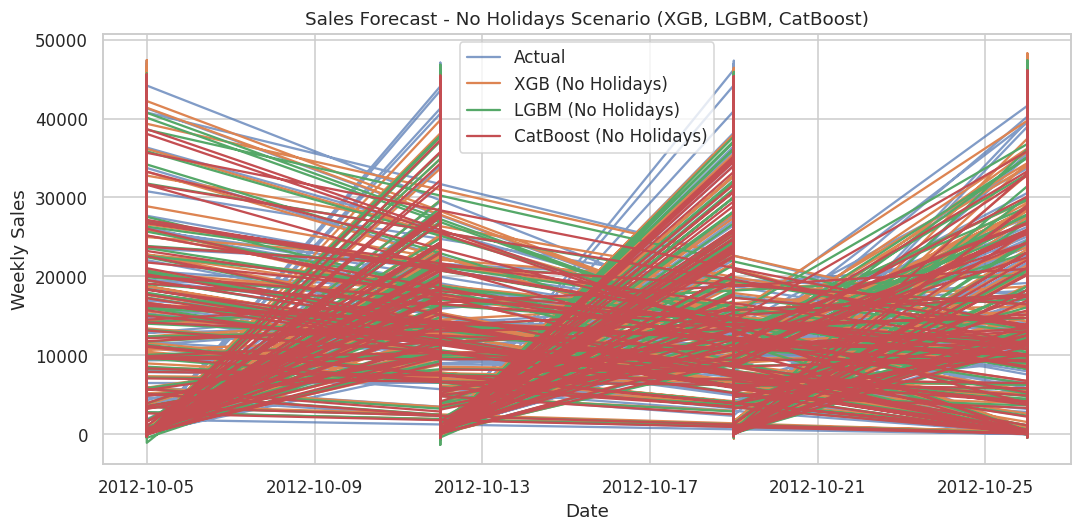

In [76]:
# ------------------------
# ⚡ Libraries
# ------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------
# ⚡ Settings
# ------------------------
RANDOM_STATE = 42
TARGET = "Weekly_Sales"

# ------------------------
# ⚡ Prepare Data
# ------------------------
df['Date'] = pd.to_datetime(df['Date'])

# Exclude target and date for tree-based features
tree_feats = [col for col in df.columns if col not in ['Date', TARGET]]

# ------------------------
# ⚡ Encode categorical columns safely
# ------------------------
cat_cols = ['Type']  # Add more if needed
for col in cat_cols:
    df[col] = df[col].map({'A':0, 'B':1, 'C':2})    # Map known categories
    df[col] = df[col].fillna(-1).astype(int)        # Fill unknowns

# ------------------------
# ⚡ Ensure all tree features are numeric
# ------------------------
for col in tree_feats:
    if df[col].dtype == 'object':
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Fill remaining NaNs
df[tree_feats] = df[tree_feats].fillna(0)

# ------------------------
# ⚡ Helper: Remove Outliers with IQR
# ------------------------
def remove_outliers_iqr(df, col="Weekly_Sales"):
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[col] >= Q1 - 1.5*IQR) & (df[col] <= Q3 + 1.5*IQR)]

# ------------------------
# 1️⃣ Prepare Train/Test
# ------------------------
best_scenario_df = remove_outliers_iqr(df.copy())
train_df = best_scenario_df[best_scenario_df['Date'] < '2012-10-01']
test_df  = best_scenario_df[best_scenario_df['Date'] >= '2012-10-01']

X_train, y_train = train_df[tree_feats], train_df[TARGET]
X_test, y_test   = test_df[tree_feats], test_df[TARGET]

# ------------------------
# ⚡ Models
# ------------------------
models = {
    'XGB': XGBRegressor(
        random_state=RANDOM_STATE, n_estimators=929, learning_rate=0.08,
        max_depth=7, subsample=0.8, colsample_bytree=0.8, tree_method='hist'
    ),
    'LGBM': LGBMRegressor(
        random_state=RANDOM_STATE, n_estimators=800, learning_rate=0.07,
        max_depth=7, subsample=0.8, colsample_bytree=0.8
    ),
    'CatBoost': CatBoostRegressor(
        random_state=RANDOM_STATE, iterations=600, learning_rate=0.05,
        depth=7, verbose=0
    )
}

fitted_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    fitted_models[name] = model

# ------------------------
# 2️⃣ Feature Importance (Combined Plot)
# ------------------------
def plot_feature_importances_combined(models, features, top_n=15):
    n_models = len(models)
    fig, axes = plt.subplots(1, n_models, figsize=(18, 6), sharey=True)

    for ax, (name, model) in zip(axes, models.items()):
        if hasattr(model, 'feature_importances_'):
            fi_df = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
            fi_df = fi_df.sort_values('Importance', ascending=False).head(top_n)
            sns.barplot(x='Importance', y='Feature', data=fi_df, palette='viridis', ax=ax)
            ax.set_title(f'{name} - Top {top_n}', fontsize=12)
            ax.set_xlabel('Importance')
            ax.set_ylabel('Feature' if ax==axes[0] else '')

    plt.tight_layout()
    plt.show()

# Usage
plot_feature_importances_combined(fitted_models, tree_feats, top_n=15)

# ------------------------
# 3️⃣ Residual Analysis (Combined)
# ------------------------
def plot_residuals_combined(models, X_test, y_test, dates):
    n_models = len(models)
    fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 10))

    for i, (name, model) in enumerate(models.items()):
        y_pred = model.predict(X_test)
        residuals = y_test - y_pred
        resid_df = pd.DataFrame({'Date': dates, 'Residuals': residuals})

        # Scatter residuals
        axes[0, i].scatter(y_pred, residuals, alpha=0.3)
        axes[0, i].axhline(0, color='red', linestyle='--')
        axes[0, i].set_xlabel('Predicted Sales')
        axes[0, i].set_ylabel('Residuals' if i==0 else '')
        axes[0, i].set_title(f'{name} - Residuals Scatter')

        # Residuals over time
        sns.lineplot(x='Date', y='Residuals', data=resid_df, ax=axes[1, i])
        axes[1, i].axhline(0, color='red', linestyle='--')
        axes[1, i].set_xlabel('Date')
        axes[1, i].set_ylabel('Residuals' if i==0 else '')
        axes[1, i].set_title(f'{name} - Residuals Over Time')

    plt.tight_layout()
    plt.show()

# Usage
plot_residuals_combined(fitted_models, X_test, y_test, test_df['Date'])


# ------------------------
# 4️⃣ What-If Scenario Simulation
# ------------------------
scenarios = {
    'All Holidays': 1,
    'No Holidays': 0
}

for scenario_name, holiday_val in scenarios.items():
    scenario_df = test_df.copy()
    scenario_df['IsHoliday'] = holiday_val
    X_scenario = scenario_df[tree_feats]

    plt.figure(figsize=(10,5))
    plt.plot(test_df['Date'], y_test, label='Actual', alpha=0.7)

    for name, model in fitted_models.items():
        preds_scenario = model.predict(X_scenario)
        plt.plot(test_df['Date'], preds_scenario, label=f'{name} ({scenario_name})')

    plt.title(f'Sales Forecast - {scenario_name} Scenario (XGB, LGBM, CatBoost)')
    plt.xlabel('Date')
    plt.ylabel('Weekly Sales')
    plt.legend()
    plt.tight_layout()
    plt.show()


# Exporting via joblib

In [78]:
import joblib
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ------------------------
# 1️⃣ Define training function for all three models
# ------------------------
def train_and_evaluate_all(X_train, X_test, y_train, y_test, random_state=42):
    fitted_models = {}

    # ---- XGBoost ----
    xgb_model = XGBRegressor(
        random_state=random_state,
        n_estimators=929,
        learning_rate=0.08,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist'
    )
    xgb_model.fit(X_train, y_train)
    fitted_models['XGB'] = xgb_model

    # ---- LightGBM ----
    lgbm_model = LGBMRegressor(
        random_state=random_state,
        n_estimators=1000,
        learning_rate=0.08,
        max_depth=7,
        subsample=0.8,
        colsample_bytree=0.8
    )
    lgbm_model.fit(X_train, y_train)
    fitted_models['LGBM'] = lgbm_model

    # ---- CatBoost ----
    cat_model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.08,
        depth=7,
        random_seed=random_state,
        verbose=0
    )
    cat_model.fit(X_train, y_train)
    fitted_models['CatBoost'] = cat_model

    # ---- Evaluate ----
    results = {}
    for name, model in fitted_models.items():
        preds = model.predict(X_test)
        results[name] = {
            'RMSE': mean_squared_error(y_test, preds, squared=False),
            'MAE': mean_absolute_error(y_test, preds),
            'R2': r2_score(y_test, preds)
        }

    return results, fitted_models

# ------------------------
# 2️⃣ Run training & evaluation
# ------------------------
results, fitted_models = train_and_evaluate_all(X_train, X_test, y_train, y_test)
print(results)

# ------------------------
# 3️⃣ Save all models
# ------------------------
for name, model in fitted_models.items():
    filename = f'{name.lower()}_walmart_model.pkl'
    joblib.dump(model, filename)
    print(f"{name} model saved as '{filename}'")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.026273 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3832
[LightGBM] [Info] Number of data points in the train set: 375126, number of used features: 22
[LightGBM] [Info] Start training from score 10548.214894
{'XGB': {'RMSE': 1529.559247731159, 'MAE': 901.5886317910544, 'R2': 0.9813683797168985}, 'LGBM': {'RMSE': 1554.1899415901787, 'MAE': 908.7953922686701, 'R2': 0.9807634934689063}, 'CatBoost': {'RMSE': 1541.9532663638372, 'MAE': 909.4559321363928, 'R2': 0.9810652123511329}}
XGB model saved as 'xgb_walmart_model.pkl'
LGBM model saved as 'lgbm_walmart_model.pkl'
CatBoost model saved as 'catboost_walmart_model.pkl'


# Streamlit

In [ ]:
# streamlit_walmart_dashboard.py
import streamlit as st
import pandas as pd
import joblib
import matplotlib.pyplot as plt

# ------------------------
# Load saved models
# ------------------------
xgb_model = joblib.load('xgb_walmart_model.pkl')
cat_model = joblib.load('catboost_walmart_model.pkl')
lgbm_model = joblib.load('lgbm_walmart_model.pkl')

# ------------------------
# Page config
# ------------------------
st.set_page_config(page_title="🛒 Walmart Weekly Sales Prediction", layout="wide")

# ------------------------
# Title
# ------------------------
st.title("🛒 Walmart Weekly Sales Prediction Dashboard")
st.markdown("Predict weekly sales for a given store, department, and week data with visual insights.")

# ------------------------
# Layout: Inputs left, graphs right
# ------------------------
input_col, graph_col = st.columns([1,2])

with input_col:
    st.header("Enter Store Details")
    
    # ---- Model Selection ----
    model_choice = st.selectbox("Select Model 🔧", ["XGBoost", "CatBoost", "LightGBM"], help="Choose the ML model for prediction")
    
    store = st.number_input("Store ID (?)", min_value=1, value=1, help="Unique identifier for the store")
    dept = st.number_input("Department ID (?)", min_value=1, value=1, help="Unique identifier for the department")
    store_type = st.selectbox("Store Type (?)", ["A","B","C"], help="Categorical type of the store")
    is_holiday = st.selectbox("Holiday? (?)", ["No","Yes"], help="Whether the current week is a holiday")
    size = st.number_input("Store Size (sq ft) (?)", value=150000, help="Physical size of the store in square feet")
    temperature = st.number_input("Temperature (°F) (?)", value=60.0, help="Average temperature during the week")
    fuel_price = st.number_input("Fuel Price ($) (?)", value=3.5, help="Fuel price during the week")
    CPI = st.number_input("Consumer Price Index (CPI) (?)", value=210.0, help="Economic indicator affecting sales")
    unemployment = st.number_input("Unemployment Rate (%) (?)", value=7.0, help="Local unemployment rate")
    
    st.subheader("Markdown Discounts")
    markdown1 = st.number_input("MarkDown1 ($) (?)", value=0.0, help="Promotional markdown 1")
    markdown2 = st.number_input("MarkDown2 ($) (?)", value=0.0, help="Promotional markdown 2")
    markdown3 = st.number_input("MarkDown3 ($) (?)", value=0.0, help="Promotional markdown 3")
    markdown4 = st.number_input("MarkDown4 ($) (?)", value=0.0, help="Promotional markdown 4")
    markdown5 = st.number_input("MarkDown5 ($) (?)", value=0.0, help="Promotional markdown 5")
    
    st.subheader("Date & Lag Features")
    year = st.number_input("Year (?)", min_value=2010, max_value=2025, value=2012, help="Year of prediction")
    month = st.number_input("Month (?)", min_value=1, max_value=12, value=1, help="Month of prediction")
    week = st.number_input("Week (?)", min_value=1, max_value=53, value=1, help="Week number of prediction")
    day = st.number_input("Day (?)", min_value=1, max_value=31, value=1, help="Day of the week")
    lag_1 = st.number_input("Previous Week Sales (Lag 1) (?)", value=20000.0, help="Sales from last week")
    lag_2 = st.number_input("2 Weeks Ago Sales (Lag 2) (?)", value=21000.0, help="Sales from 2 weeks ago")
    lag_3 = st.number_input("3 Weeks Ago Sales (Lag 3) (?)", value=22000.0, help="Sales from 3 weeks ago")
    rolling_mean_4 = st.number_input("4-Week Avg Sales (?)", value=21500.0, help="Rolling mean of past 4 weeks")
    rolling_std_4 = st.number_input("4-Week Sales Std Dev (?)", value=1500.0, help="Rolling standard deviation of past 4 weeks")

# ------------------------
# Prepare input
# ------------------------
holiday_val = 1 if is_holiday=="Yes" else 0
type_val = {'A':0,'B':1,'C':2}[store_type]

input_df = pd.DataFrame([{
    'Store': store,
    'Dept': dept,
    'Type': type_val,
    'IsHoliday': holiday_val,
    'Size': size,
    'Temperature': temperature,
    'Fuel_Price': fuel_price,
    'CPI': CPI,
    'Unemployment': unemployment,
    'MarkDown1': markdown1,
    'MarkDown2': markdown2,
    'MarkDown3': markdown3,
    'MarkDown4': markdown4,
    'MarkDown5': markdown5,
    'Year': year,
    'Month': month,
    'Week': week,
    'Day': day,
    'Lag_1': lag_1,
    'Lag_2': lag_2,
    'Lag_3': lag_3,
    'Rolling_Mean_4': rolling_mean_4,
    'Rolling_Std_4': rolling_std_4
}])

# ------------------------
# Prediction & Visuals
# ------------------------
with graph_col:
    if st.button("Predict Weekly Sales 💵"):
        # ---- Choose model based on selection ----
        if model_choice == "XGBoost":
            model = xgb_model
        elif model_choice == "CatBoost":
            model = cat_model
        else:
            model = lgbm_model
        
        pred = model.predict(input_df)[0]
        st.success(f"📈 Predicted Weekly Sales ({model_choice}): ${pred:,.2f}")
        
        # ---- 1️⃣ Recent Sales Trends ----
        st.subheader("Recent Sales Trends")
        fig1, ax1 = plt.subplots()
        ax1.bar(["Lag1","Lag2","Lag3","4-Week Avg"], [lag_1, lag_2, lag_3, rolling_mean_4], color='skyblue')
        ax1.set_ylabel("Sales ($)")
        ax1.set_title("Sales Comparison (Past Weeks)")
        for i, val in enumerate([lag_1, lag_2, lag_3, rolling_mean_4]):
            ax1.text(i, val + 200, f"${val:,.0f}", ha='center')
        st.pyplot(fig1)
        
        # ---- 2️⃣ Predicted vs Lag Trend ----
        st.subheader("Predicted vs Previous Sales")
        fig2, ax2 = plt.subplots()
        weeks = ["Lag3","Lag2","Lag1","Predicted"]
        sales = [lag_3, lag_2, lag_1, pred]
        ax2.plot(weeks, sales, marker='o', color='green')
        ax2.set_ylabel("Sales ($)")
        ax2.set_title("Trend Analysis")
        for i, val in enumerate(sales):
            ax2.text(i, val + 200, f"${val:,.0f}", ha='center')
        st.pyplot(fig2)
        
 